In [1]:
import pandas as pd
from numba import jit
import numpy as np
from dask import dataframe as dd
import src.features.bars as brs
import src.features.snippets as snp
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
from pymc3 import *
import arviz as az
from pandas import DataFrame

<font size=5 color=#CD2626 >Read and Clean Data (provided by kibot.com)  
    <font size=3 color=#292929 >a. rename ('Date', 'Time', 'Price', 'Bid', 'Ask', 'Size')  
        <font size=3 color=#292929 >b. assign 'size' as 'v' (volume)  
            <font size=3 color=#292929 >c. define 'dv' (dollar volume): 'dv' = 'price' * 'size'  
                <font size=3 color=#292929 >d. combine 'Date' and 'Time' as 'dates  
                    <font size=3 color=#292929 >e. drop duplicates  
                        <font size=3 color=#292929 >f. remove outliers

In [229]:
def read_kibot_ticks(fp):
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header=None)
          .rename(columns=dict(zip(range(len(cols)),cols)))
          .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')))
          .assign(v=lambda df: df['size']) # volume
          .assign(dv=lambda df: df['price']*df['size']) # dollar volume
          .drop(['date','time'],axis=1)
          .set_index('dates')
          .drop_duplicates())
    return df
    
df = read_kibot_ticks(r'C:\Users\xiwei\Downloads\IVE_tickbidask.txt')


In [230]:
df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.7900,50.70,50.79,100,100,5.079000e+03
2009-09-28 09:30:00,50.7100,50.70,50.79,638,638,3.235298e+04
2009-09-28 09:31:32,50.7500,50.75,50.76,100,100,5.075000e+03
2009-09-28 09:31:33,50.7500,50.72,50.75,100,100,5.075000e+03
2009-09-28 09:31:50,50.7500,50.73,50.76,300,300,1.522500e+04
2009-09-28 09:31:51,50.7500,50.74,50.76,300,300,1.522500e+04
2009-09-28 09:32:06,50.7800,50.76,50.78,300,300,1.523400e+04
2009-09-28 09:32:06,50.7800,50.76,50.78,500,500,2.539000e+04
2009-09-28 09:32:06,50.7800,50.76,50.78,100,100,5.078000e+03


In [12]:
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad(median absolute deviation)
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [13]:
mad = mad_outlier(df.price.values.reshape(-1,1))

<font size=3 color=#292929 >Outliers

In [14]:
df.loc[mad]

,price,bid,ask,size,v,dv
dates,,,,,,
2010-05-06 14:49:07,0.11,0.10,44.03,500,500,55.0
2010-05-06 14:53:30,1.10,1.10,30.28,2600,2600,2860.0
2010-05-06 14:55:32,1.10,1.10,50.57,300,300,330.0
2010-05-06 14:55:32,1.10,1.10,50.57,100,100,110.0
2010-05-06 14:55:32,1.10,1.00,50.57,200,200,220.0
2010-05-06 14:55:32,1.10,1.00,50.57,700,700,770.0
2010-05-06 14:55:32,1.10,1.00,50.57,1200,1200,1320.0
2010-05-06 14:55:32,1.10,0.55,50.57,500,500,550.0
2010-05-06 14:55:32,1.10,0.55,50.57,100,100,110.0


<font size=3 color=#292929 >Clean_data

In [15]:
df = df.loc[~mad]
df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.7900,50.70,50.79,100,100,5.079000e+03
2009-09-28 09:30:00,50.7100,50.70,50.79,638,638,3.235298e+04
2009-09-28 09:31:32,50.7500,50.75,50.76,100,100,5.075000e+03
2009-09-28 09:31:33,50.7500,50.72,50.75,100,100,5.075000e+03
2009-09-28 09:31:50,50.7500,50.73,50.76,300,300,1.522500e+04
2009-09-28 09:31:51,50.7500,50.74,50.76,300,300,1.522500e+04
2009-09-28 09:32:06,50.7800,50.76,50.78,300,300,1.523400e+04
2009-09-28 09:32:06,50.7800,50.76,50.78,500,500,2.539000e+04
2009-09-28 09:32:06,50.7800,50.76,50.78,100,100,5.078000e+03


<font size=5 color=#CD2626 >Resample dataset  
    <font size=3 color=#292929 >a. combine the event that happens as the same time (mean())  
        <font size=3 color=#292929 >b. dropna

In [21]:
def dask_resample(ser, freq='L'):
    dds = dd.from_pandas(ser, chunksize=len(ser)//100)
    tdf = (dds
           .resample(freq)
           .mean()
           .dropna()
          ).compute()
    return tdf

dv_rs = dask_resample(df, '1s')

C:\Users\xiwei\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:391: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  tz=idx.tz, name=idx.name)


In [22]:
dv_rs

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.750000,50.700000,50.790000,369.000000,369.000000,1.871599e+04
2009-09-28 09:31:32,50.750000,50.750000,50.760000,100.000000,100.000000,5.075000e+03
2009-09-28 09:31:33,50.750000,50.720000,50.750000,100.000000,100.000000,5.075000e+03
2009-09-28 09:31:50,50.750000,50.730000,50.760000,300.000000,300.000000,1.522500e+04
2009-09-28 09:31:51,50.750000,50.740000,50.760000,300.000000,300.000000,1.522500e+04
2009-09-28 09:32:06,50.780000,50.760000,50.780000,300.000000,300.000000,1.523400e+04
2009-09-28 09:32:56,50.822600,50.810000,50.830000,100.000000,100.000000,5.082260e+03
2009-09-28 09:33:02,50.810000,50.800000,50.810000,400.000000,400.000000,2.032400e+04
2009-09-28 09:33:08,50.820000,50.800000,50.830000,399.000000,399.000000,2.027718e+04


<font size=6 color=#292929 >#Labeling Part

<font size=5 color=#CD2626 >feature extraction  
    <font size=3 color=#292929 >a. get bars (dollar bars//every 1,000,000)  
        <font size=3 color=#292929 >b. get daily volatility (time_window = 100)  
            <font size=3 color=#292929 >c. get features from bars (t_volatility > daily_vol)  
                <font size=3 color=#292929 >d. give close time of each features

In [29]:
def getDailyVol(close,span0=100):
    #get dynamic thresholds
    # daily vol reindexed to close
    #using a span of 100 days to an exponentially weighted moving standard deviation
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [42]:
dbars = brs.dollar_bar_df(dv_rs, 'dv', 1_000_000)


close = dbars.price.copy()
dailyVol = snp.getDailyVol(close)


tEvents = snp.getTEvents(close,h=dailyVol.mean())


t1 = snp.addVerticalBarrier(tEvents, close)


## select profit taking stoploss factor
#ptS1[0]: the factor that multiplies trgt to set the width of the upper barrier
#ptS1[1]: the factor that multiplies trgt to set the width of the lower barrier
ptsl = [1,1]
# target is dailyVol computed earlier//trgt
target=dailyVol
# select minRet
minRet = 0.01
# get cpu count - 1
cpus = cpu_count() - 1

events = snp.getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)


100%|█████████████████████████████████████████████████████████████████████████| 39992/39992 [00:02<00:00, 18484.69it/s]
C:\Users\xiwei\Adv_Fin_ML_Exercises-master\notebooks\src\features\snippets.py:93: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt=trgt.loc[tEvents]
2019-06-19 10:57:17.086174 100.0% applyPtSlOnT1 done after 0.07 minutes. Remaining 0.0 minutes..


In [43]:
events

,t1,trgt
2009-10-05 14:55:48,2009-10-06 11:32:02,0.013612
2009-10-06 09:29:52,2009-10-07 09:47:16,0.015728
2009-10-06 11:32:02,2009-10-07 11:48:22,0.016744
2009-10-06 14:07:37,2009-10-07 14:22:36,0.016971
2009-10-06 16:00:57,2009-10-08 09:29:51,0.016749
2009-10-07 11:48:22,2009-10-08 12:07:39,0.015910
2009-10-07 15:34:00,2009-10-08 15:38:28,0.015128
2009-10-08 09:29:51,2009-10-09 09:31:12,0.014877
2009-10-08 14:29:03,2009-10-09 14:58:12,0.014531
2009-10-09 12:02:32,2009-10-12 09:31:02,0.013678


<font size=5 color=#CD2626 >Labeling  
    <font size=3 color=#292929 >a. based on return (label 1 if>0; label -1 else)  
        <font size=3 color=#292929 >b. drop observations associated with classes that appear less

In [44]:
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] #only for meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 #only for meta-labeling
    return out

In [53]:
labels = getBins(events, close)
print(labels.bin.value_counts())

 1.0    1024
-1.0     766
 0.0       2
Name: bin, dtype: int64


In [46]:
labels

,ret,bin
2009-10-05 14:55:48,0.015732,1.0
2009-10-06 09:29:52,0.000982,1.0
2009-10-06 11:32:02,-0.006544,-1.0
2009-10-06 14:07:37,0.002648,1.0
2009-10-06 16:00:57,0.012524,1.0
2009-10-07 11:48:22,0.014797,1.0
2009-10-07 15:34:00,0.008485,1.0
2009-10-08 09:29:51,-0.003092,-1.0
2009-10-08 14:29:03,0.002495,1.0
2009-10-09 12:02:32,0.009030,1.0


In [48]:
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [50]:
clean_labels = dropLabels(labels)

C:\Users\xiwei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


dropped label:  0.0 0.0011160714285714285


C:\Users\xiwei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys


In [60]:
clean_labels

,ret,bin
2009-10-05 14:55:48,0.015732,1.0
2009-10-06 09:29:52,0.000982,1.0
2009-10-06 11:32:02,-0.006544,-1.0
2009-10-06 14:07:37,0.002648,1.0
2009-10-06 16:00:57,0.012524,1.0
2009-10-07 11:48:22,0.014797,1.0
2009-10-07 15:34:00,0.008485,1.0
2009-10-08 09:29:51,-0.003092,-1.0
2009-10-08 14:29:03,0.002495,1.0
2009-10-09 12:02:32,0.009030,1.0


<font size=5 color=#CD2626 >Develop moving average crossover strategy.  
    <font size=3 color=#292929 >For each observation, the model suggests a side but not size of the bet(primary model)

In [207]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))

In [208]:
close_df

,price,fast,slow
dates,,,
2009-09-28 09:53:49,51.138000,51.138000,51.138000
2009-09-28 10:06:04,51.190000,51.167714,51.165733
2009-09-28 10:19:50,51.210000,51.186000,51.182497
2009-09-28 10:32:01,51.379725,51.256848,51.242073
2009-09-28 10:53:46,51.330000,51.280826,51.264637
2009-09-28 11:22:01,51.350000,51.301864,51.283995
2009-09-28 11:34:21,51.378600,51.324003,51.303468
2009-09-28 11:53:11,51.414800,51.349228,51.324669
2009-09-28 12:30:58,51.475000,51.383223,51.351539


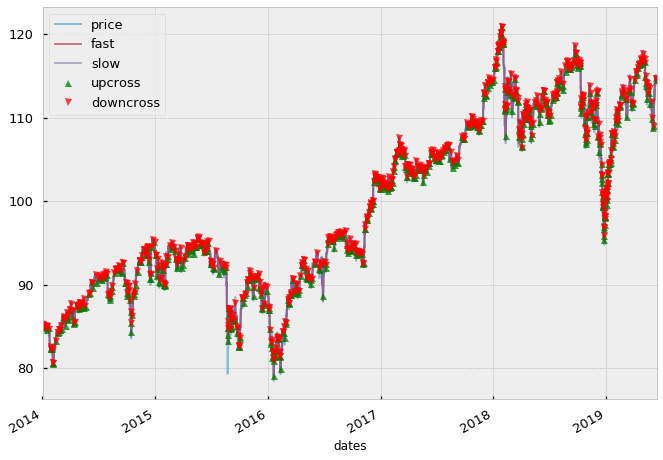

In [209]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

<font size=5 color=#CD2626 >meta-labeling  
    <font size=3 color=#292929 >events extraction with sides (trgt: dailyVol; minRet: 0.01)

In [211]:
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()

In [212]:
side

dates
2009-09-30 09:45:21   -1
2009-10-05 10:41:50    1
2009-10-16 10:40:43   -1
2009-10-19 10:46:14    1
2009-10-20 11:50:28   -1
2009-10-21 10:57:04    1
2009-10-21 15:32:09   -1
2009-10-22 15:49:30    1
2009-10-23 11:44:14   -1
2009-10-29 13:40:22    1
2009-10-30 11:51:20   -1
2009-11-02 10:44:30    1
2009-11-02 12:23:50   -1
2009-11-03 13:41:16    1
2009-11-12 14:28:53   -1
2009-11-13 13:30:32    1
2009-11-13 15:12:38   -1
2009-11-16 10:11:56    1
2009-11-19 09:45:02   -1
2009-11-23 10:00:28    1
2009-11-27 10:01:54   -1
2009-12-01 11:22:53    1
2009-12-03 15:51:47   -1
2009-12-04 09:39:34    1
2009-12-04 12:04:05   -1
2009-12-07 10:05:19    1
2009-12-07 15:52:10   -1
2009-12-10 10:44:28    1
2009-12-15 15:36:49   -1
2009-12-16 10:08:40    1
                      ..
2019-05-01 15:39:12   -1
2019-05-03 10:06:20    1
2019-05-06 09:30:12   -1
2019-05-06 15:00:01    1
2019-05-07 09:30:00   -1
2019-05-08 11:02:17    1
2019-05-08 15:59:58   -1
2019-05-09 13:52:54    1
2019-05-10 09:30:00

In [215]:
minRet = .01 
ptsl=[1,2]

dailyVol = snp.getDailyVol(close_df['price'])
tEvents = snp.getTEvents(close_df['price'],h=dailyVol.mean())
t1 = snp.addVerticalBarrier(tEvents, close_df['price'], numDays=1)

ma_events = snp.getEvents(close_df['price'],tEvents,ptsl,target,minRet,cpus,
                      t1=t1,side=side)

100%|█████████████████████████████████████████████████████████████████████████| 39992/39992 [00:02<00:00, 17819.52it/s]
C:\Users\xiwei\Adv_Fin_ML_Exercises-master\notebooks\src\features\snippets.py:93: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt=trgt.loc[tEvents]
C:\Users\xiwei\Adv_Fin_ML_Exercises-master\notebooks\src\features\snippets.py:99: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
2019-06-19 14:26:35.956724 100.0% applyPtSlOnT1 done after 0.07 minutes. Remaining 0.0 minutes..


In [216]:
ma_events

,side,t1,trgt
2009-10-05 14:55:48,NaN,2009-10-06 15:35:49,0.013612
2009-10-06 09:29:52,NaN,2009-10-07 09:47:16,0.015728
2009-10-06 11:32:02,NaN,2009-10-07 11:48:22,0.016744
2009-10-06 14:07:37,NaN,2009-10-07 14:22:36,0.016971
2009-10-06 16:00:57,NaN,2009-10-08 09:29:51,0.016749
2009-10-07 11:48:22,NaN,2009-10-08 12:07:39,0.015910
2009-10-07 15:34:00,NaN,2009-10-08 15:38:28,0.015128
2009-10-08 09:29:51,NaN,2009-10-09 09:31:12,0.014877
2009-10-08 14:29:03,NaN,2009-10-09 14:58:12,0.014531
2009-10-09 12:02:32,NaN,2009-10-12 09:31:02,0.013678


In [217]:
ma_events.side.value_counts()

 1.0    73
-1.0    60
Name: side, dtype: int64

In [218]:
ma_side = ma_events.dropna().side

<font size=3 color=#292929 >get bins (1, if return>0; 0, else)

In [220]:
ma_bins = getBinsNew(ma_events,close_df['price'], t1).dropna()

In [221]:
ma_bins

,ret,bin
2009-10-29 13:40:22,-0.021789,0.0
2009-10-30 11:51:20,0.016593,1.0
2009-11-13 15:12:38,-0.018300,0.0
2009-11-16 10:11:56,-0.005795,0.0
2009-11-23 10:00:28,-0.010502,0.0
2010-02-08 15:25:07,-0.011441,0.0
2010-02-09 09:35:12,-0.006278,0.0
2010-02-10 13:40:31,0.005039,1.0
2010-02-11 09:51:05,0.001172,1.0
2010-02-11 12:13:56,-0.001384,0.0


In [222]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')

In [223]:
Xx

,ret,bin,side
2009-10-29 13:40:22,-0.021789,0.0,1
2009-10-30 11:51:20,0.016593,1.0,-1
2009-11-13 15:12:38,-0.018300,0.0,-1
2009-11-16 10:11:56,-0.005795,0.0,1
2009-11-23 10:00:28,-0.010502,0.0,1
2010-02-08 15:25:07,-0.011441,0.0,-1
2010-02-09 09:35:12,-0.006278,0.0,1
2010-02-10 13:40:31,0.005039,1.0,1
2010-02-11 09:51:05,0.001172,1.0,-1
2010-02-11 12:13:56,-0.001384,0.0,1


<font size=3 color=#292929 >Train Random Forest to decide whether to trade or not {0,1} (secondary model)

In [224]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

              precision    recall  f1-score   support

         0.0       0.32      0.32      0.32        34
         1.0       0.30      0.30      0.30        33

   micro avg       0.31      0.31      0.31        67
   macro avg       0.31      0.31      0.31        67
weighted avg       0.31      0.31      0.31        67



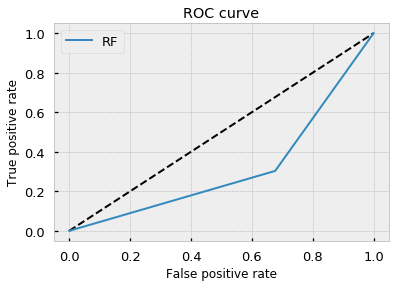

In [226]:
X = ma_side.values.reshape(-1,1)
y = ma_bins.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=777)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

<font size=6 color=#292929 >#Features Part

<font size=5 color=#CD2626 >feature extraction  
    <font size=3 color=#292929 >a. dollar bars (every 1,000,000)  
        <font size=3 color=#292929 >b. daily volatility(time_window = 100)  
        <font size=3 color=#292929 >c. feature extraction (volatility > mean(daily_volatility))  
        <font size=3 color=#292929 >d. feature extraction (volatility > 0.005)

In [54]:
dbars = brs.dollar_bar_df(dv_rs, 'dv', 1_000_000)


close = dbars.price.copy()
dailyVol = snp.getDailyVol(close)


tEvents = snp.getTEvents(close,h=dailyVol.mean())


t1 = snp.addVerticalBarrier(tEvents, close)


# select profit taking stoploss factor
ptsl = [1,1]
# target is dailyVol computed earlier
target=dailyVol
# select minRet
minRet = 0.005
# get cpu count - 1
cpus = cpu_count() - 1

events = snp.getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)


100%|█████████████████████████████████████████████████████████████████████████| 39992/39992 [00:02<00:00, 18105.26it/s]
C:\Users\xiwei\Adv_Fin_ML_Exercises-master\notebooks\src\features\snippets.py:93: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt=trgt.loc[tEvents]
2019-06-19 11:07:25.662138 100.0% applyPtSlOnT1 done after 0.1 minutes. Remaining 0.0 minutes...


In [55]:
events

,t1,trgt
2009-09-30 09:45:21,2009-09-30 10:03:53,0.005247
2009-09-30 11:32:34,2009-10-01 10:00:48,0.007600
2009-09-30 14:41:36,2009-10-01 09:43:58,0.007095
2009-10-01 09:43:58,2009-10-01 11:12:07,0.007157
2009-10-01 10:36:11,2009-10-01 13:33:25,0.006801
2009-10-01 13:33:25,2009-10-02 09:44:14,0.007945
2009-10-01 15:30:21,2009-10-02 09:44:14,0.009027
2009-10-02 09:44:14,2009-10-02 10:35:05,0.009808
2009-10-02 10:35:05,2009-10-05 09:51:42,0.009765
2009-10-02 13:20:04,2009-10-05 09:51:42,0.008904


<font size=5 color=#CD2626 >calculate number of coEvents
    <font size=3 color=#CD2626 >compute the number of overlapping outcomes at each point in time  
        <font size=3 color=#292929 >a. out['w']: calculate the average uniqueness of each event 

In [205]:
numCoEvents = snp.mpPandasObj(snp.mpNumCoEvents,('molecule',events.index),                         
                              cpus,closeIdx=close.index,t1=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()
##determination of sample weight by absolute return attribution (total weight)
#the sum of the attibuted returns over the event's lifespan
out['tW'] = snp.mpPandasObj(snp.mpSampleTW,('molecule',events.index),
                            cpus,t1=events['t1'],numCoEvents=numCoEvents)
#scale these weights to add up to I 
out['w']=snp.mpPandasObj(snp.mpSampleW,('molecule',events.index),cpus,
                         t1=events['t1'],numCoEvents=numCoEvents,close=close)
out['w']*=out.shape[0]/out['w'].sum()

2019-06-19 14:06:31.557106 100.0% mpNumCoEvents done after 0.07 minutes. Remaining 0.0 minutes..
2019-06-19 14:06:36.340248 100.0% mpSampleTW done after 0.07 minutes. Remaining 0.0 minutes..
2019-06-19 14:06:41.264184 100.0% mpSampleW done after 0.07 minutes. Remaining 0.0 minutes..


In [58]:
numCoEvents

dates
2009-09-28 09:53:49    0.0
2009-09-28 10:06:04    0.0
2009-09-28 10:19:50    0.0
2009-09-28 10:32:01    0.0
2009-09-28 10:53:46    0.0
2009-09-28 11:22:01    0.0
2009-09-28 11:34:21    0.0
2009-09-28 11:53:11    0.0
2009-09-28 12:30:58    0.0
2009-09-28 13:24:28    0.0
2009-09-28 13:54:29    0.0
2009-09-28 14:15:06    0.0
2009-09-28 14:26:40    0.0
2009-09-28 14:44:10    0.0
2009-09-28 15:39:46    0.0
2009-09-28 15:51:04    0.0
2009-09-29 09:33:01    0.0
2009-09-29 10:03:18    0.0
2009-09-29 10:40:29    0.0
2009-09-29 11:18:50    0.0
2009-09-29 12:02:43    0.0
2009-09-29 12:53:47    0.0
2009-09-29 13:59:56    0.0
2009-09-29 14:59:27    0.0
2009-09-29 15:31:13    0.0
2009-09-29 15:59:59    0.0
2009-09-30 09:45:21    1.0
2009-09-30 10:03:53    1.0
2009-09-30 10:36:48    0.0
2009-09-30 11:32:34    1.0
                      ... 
2019-06-12 10:16:45    1.0
2019-06-12 10:31:21    1.0
2019-06-12 11:05:16    2.0
2019-06-12 11:08:46    2.0
2019-06-12 11:40:51    2.0
2019-06-12 12:04:27   

In [206]:
out

,tW,w
2009-09-30 09:45:21,1.000000,3.716835
2009-09-30 11:32:34,0.648148,0.977682
2009-09-30 14:41:36,0.466667,1.416062
2009-10-01 09:43:58,0.566667,2.163607
2009-10-01 10:36:11,0.750000,1.367373
2009-10-01 13:33:25,0.666667,2.477502
2009-10-01 15:30:21,0.458333,1.336232
2009-10-02 09:44:14,0.708333,0.133239
2009-10-02 10:35:05,0.717949,0.944330
2009-10-02 13:20:04,0.472222,0.545604


C:\Users\xiwei\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


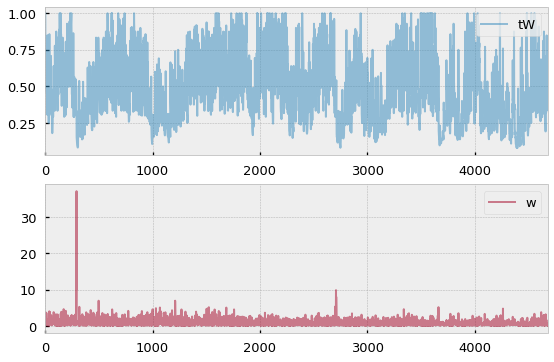

In [63]:
fig, ax = plt.subplots(figsize=(9,6))
out.reset_index(drop=True).plot(subplots=True, alpha=0.5, ax=ax);

<font size=5 color=#CD2626 >coEvents vs vol at that time period  
    <font size=3 color=#292929 >Plot the time series of number of concurrent labels on primary axis and time series of exponentially weighted moving standard deviation of returns on secondary axis

In [64]:
coEvents_std = (
    pd.DataFrame()
    .assign(
        numCoEvents = numCoEvents.reset_index(drop=True),
        std = brs.returns(dbars.price).ewm(50).std().reset_index(drop=True))
)

In [65]:
coEvents_std

,numCoEvents,std
0,0.0,NaN
1,0.0,0.000442
2,0.0,0.001545
3,0.0,0.001800
4,0.0,0.001570
5,0.0,0.001402
6,0.0,0.001273
7,0.0,0.001182
8,0.0,0.001148
9,0.0,0.001078


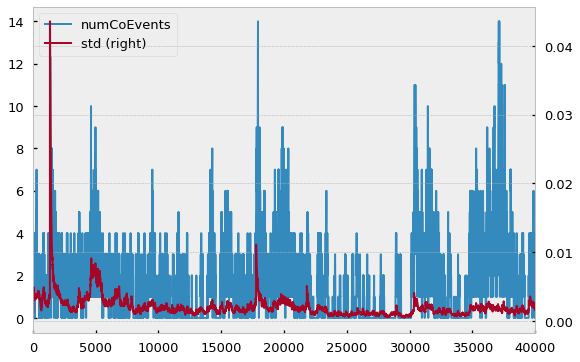

In [66]:
fig, ax = plt.subplots(figsize=(9,6))

coEvents_std.numCoEvents.plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)

<font size=5 color=#CD2626 >compute the avg uniqueness of each feature

In [129]:
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index = molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

In [154]:
uniqueness = DataFrame(mpSampleTW(t1,numCoEvents,events.index))

C:\Users\xiwei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


In [175]:
uniqueness.columns = ['uniqueness']
uniqueness

,uniqueness
0,0.000000
1,0.702381
2,0.688889
3,0.697917
4,0.754902
5,0.780702
6,0.712963
7,0.729167
8,0.717949
9,0.472222


<font size=5 color=#CD2626 >Histogram of uniqueness values 

In [176]:
uniqueness = np.array(uniqueness['uniqueness'])

In [170]:
uniqueness = DataFrame(uniqueness)

In [182]:
import matplotlib.pyplot as plt

In [157]:
where_are_nan = np.isnan(uniqueness)
where_are_inf = np.isinf(uniqueness)
uniqueness[where_are_nan] = 0
uniqueness[where_are_inf] = 0

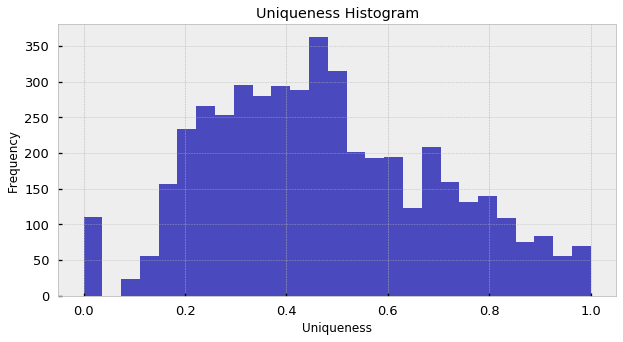

In [196]:
plt.figure(figsize = (10,5))
n, bins, patches = plt.hist(x=uniqueness, bins='auto', color='#0504aa', alpha=0.7, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Uniqueness')
plt.ylabel('Frequency')
plt.title('Uniqueness Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()


<font size=5 color=#CD2626 >That's all

In [68]:
lag = 1
lag_col = f'tW_lag_{lag}'
out[lag_col] = out['tW'].shift(lag)

In [69]:
out.dropna()

,tW,w,tW_lag_1
2009-09-30 11:32:34,0.648148,0.977682,1.000000
2009-09-30 14:41:36,0.466667,1.416062,0.648148
2009-10-01 09:43:58,0.566667,2.163607,0.466667
2009-10-01 10:36:11,0.750000,1.367373,0.566667
2009-10-01 13:33:25,0.666667,2.477502,0.750000
2009-10-01 15:30:21,0.458333,1.336232,0.666667
2009-10-02 09:44:14,0.708333,0.133239,0.458333
2009-10-02 10:35:05,0.717949,0.944330,0.708333
2009-10-02 13:20:04,0.472222,0.545604,0.717949
2009-10-05 09:51:42,0.833333,3.594370,0.472222


In [77]:
tryy = out.dropna()[:300]

In [73]:
with pm.Model() as mdl:
    pm.GLM.from_formula(f'tW ~ {lag_col}', out.dropna())
    trace = pm.sample(3000, cores=1, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, tW_lag_1, Intercept]
  6%|████▉                                                                       | 225/3500 [17:45<17:26:50, 19.18s/it]C:\Users\xiwei\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


In [78]:
with pm.Model() as mdl:
    pm.GLM.from_formula(f'tW ~ {lag_col}', tryy)
    trace = pm.sample(3000, cores=1, nuts_kwargs={'target_accept':0.95})#draw 30000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, tW_lag_1, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [11:39<00:00,  4.09it/s]


In [115]:
def plot_traces(traces, retain=0):
    ax = az.plot_trace(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

C:\Users\xiwei\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


<Figure size 648x432 with 0 Axes>

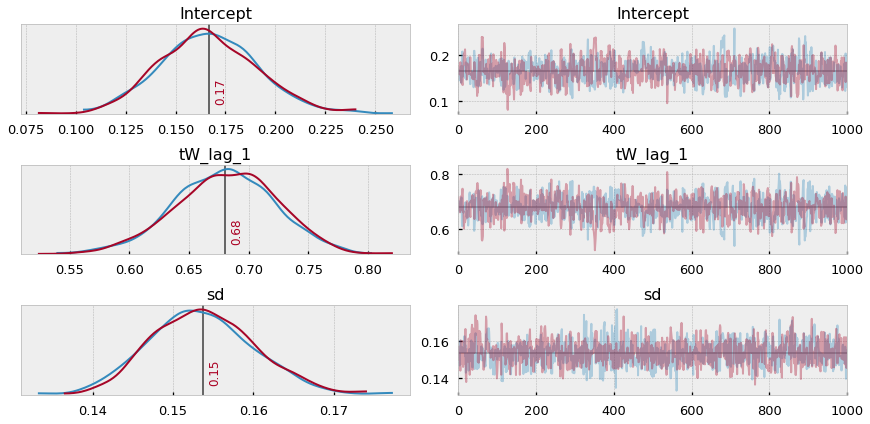

In [116]:
plt.figure(figsize=(9, 6))
plot_traces(trace, retain=1_000)
plt.tight_layout();

In [100]:
df_smry = pm.summary(trace[1000:])
df_smry

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,0.165913,0.023987,0.000681,0.121888,0.213493,1321.601164,1.000615
tW_lag_1,0.681667,0.041965,0.001230,0.597712,0.762333,1262.271801,1.001832
sd,0.153626,0.006366,0.000152,0.141686,0.166662,1862.822444,0.999834
